<a href="https://colab.research.google.com/github/BluBloos/3D-Hand-Tracking/blob/idea2/src/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [ ]:
########################################### PARAMS ########################################### 
BATCH_SIZE = 20
IMAGE_SIZE = 224
GRAYSCALE = False
IMAGE_CHANNELS = 1 if GRAYSCALE else 3

########################################### HANDLE DIFFS WHEN RUNNING IN COLAB ##################################
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import sys
if (IN_COLAB):
  sys.path.insert(1, '/content/src/')
  !echo "Initializing github repository"
  !ls -la
  !rm -r .config/
  !rm -r sample_data/
  !git clone https://github.com/BluBloos/QMIND2021-2022/ .  

!git pull 

########################################### EXTERNAL LIBRARIES ###########################################
import os
import numpy as np
import time
import tensorflow as tf
from importlib import reload
tf.keras.backend.clear_session()
print("TensorFlow version:", tf.__version__)
import random

########################################### INIT QMIND_LIB ###########################################

# NOTE(Noah): gcs code will only work on the Colab. It works on either Ubuntu or macOS (no Windows support).
# I attempted to install gcsfuse on my macOS machine, but it did not work.
# gsfuse is beta software.
if IN_COLAB:
  from google.colab import auth
  auth.authenticate_user()
  # we know that we are on an Ubuntu machine.
  # Thus, installing gcsfuse will be done via the Ubuntu instructions.
  # https://github.com/GoogleCloudPlatform/gcsfuse/blob/master/docs/installing.md#ubuntu-and-debian-latest-releases
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" \
    | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  # -y in apt-get will assume "yes" as the answer to all prompts.
  # -q in apt-get will make things "quiet" for us. Nice!
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse
  !mkdir -p data
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 shd_final data

import qmind_lib as qmindlib
reload(qmindlib)

rhd_dir = 'data' if IN_COLAB else os.path.join("..", "SH_RHD")
qmindlib.init(rhd_dir, BATCH_SIZE, img_count=47)

cstr = qmindlib.cstr
y_train = qmindlib.y_train
y_test = qmindlib.y_test
k_train = qmindlib.k_train
k_test = qmindlib.k_test
y2_train = qmindlib.y2_train
y2_test = qmindlib.y2_test
train_ds = qmindlib.train_ds

qmindlib.visualize_ds()

########################################### MODEL LOADING ###########################################
MANO_DIR = os.path.join("data", "mano_v1_2") if IN_COLAB else os.path.join("..", "mano_v1_2")
import mobilehand
reload(mobilehand)
T = 3
model = mobilehand.MobileHand(IMAGE_SIZE, IMAGE_CHANNELS, MANO_DIR, T=T)
model.mobile_net.freeze()
#model.reg_module.trainable = False

### MODEL FORWARD PASS TEST ###
input_test = tf.random.uniform(shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS), dtype=tf.float32)
output_test = model(input_test) 
print(cstr("output_test ="), output_test)
### MODEL FORWARD PASS TEST ###

U = model.mano_model.U
L = model.mano_model.L
loss_fn = mobilehand.LOSS
loss_fn2 = mobilehand.LOSS2

########################################### TRAINING SETUP ###########################################
class StupidSimpleLossMetric():
  def __init__(self):
    self.losses = [] # empty python array 
  def __call__(self, loss):
    self.losses.append(loss)
  def result(self):
    return sum(self.losses) / len(self.losses)
  def reset_states(self):
    self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()

@tf.function
def train_step(input, gt):
  for t in range(T):
    with tf.GradientTape() as tape:
      beta, pose, mesh, keypoints, scale = model(input, iter=t, training=True)
      # This is the thing that takes our MANO template to the same shape as gt.
      gt_scale = tf.sqrt(tf.reduce_sum(tf.square(gt[:, 0] - gt[:, 8]), axis=1, keepdims=True)) / 0.0906426
      gt_scale = tf.expand_dims(gt_scale, axis=1) # should have shape = [bs, 1, 1]
      # apply regularization to keep corrections having estimates be on the manifold of valid hands.
      loss = loss_fn(beta, pose, L, U, scale, keypoints, gt, gt_scale) if t == T - 1 else loss_fn2(beta, pose, L, U)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

if not IN_COLAB:
  import render_ckpt
  reload(render_ckpt)
  render_checkpoint_image = render_ckpt.render_checkpoint_image

# TRAINING
The variable LAST_CHECKPOINT controls where our model training will start off from.
Leave as -1 to "start fresh".
OR adjust to any number, so long as there is a checkpoint saved for that number.

In [ ]:
########################################### PARAMS ###########################################
# BATCH_SIZE = 32
LAST_CHECKPOINT = -1
EPOCHS = 200 # sure...
optimizer.learning_rate = 1e-3

########################################### SETUP ###########################################
checkpoint_path = os.path.join("data", "checkpoints") if IN_COLAB else os.path.join("..", "checkpoints/")
!mkdir $checkpoint_path

if (LAST_CHECKPOINT > -1):
  file_path = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(LAST_CHECKPOINT))
  model.load_weights(file_path)
  print(cstr("Loaded weights from {}".format(file_path)))
else:
  LAST_CHECKPOINT = 0

########################################### TRAINING LOOP ###########################################
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Begin epoch", epoch)
  train_loss.reset_states()
  start = time.time()
  
  for img, y in train_ds:
    loss = train_step(img, y)
    train_loss(loss.numpy())    

  end = time.time()

  print(
    f'Epoch {epoch}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
  )

  # Save the model parameters
  ckpt_index = LAST_CHECKPOINT + epoch
  checkpoint_filepath = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(ckpt_index))
  model.save_weights(checkpoint_filepath)
  print(cstr("Saved weights to {}".format(checkpoint_filepath)))

  if not IN_COLAB:
    # Run the model on image 19 of the evaluation images.
    test_img = 26
    eval_image = qmindlib.download_image_legacy("training", test_img)
    annot = (y2_train[test_img], y_train[test_img], k_train[test_img])
    render_checkpoint_image(checkpoint_path, ckpt_index, model, eval_image, annot)

# MODEL EVALUATION

inference_time 0.2718650045849028


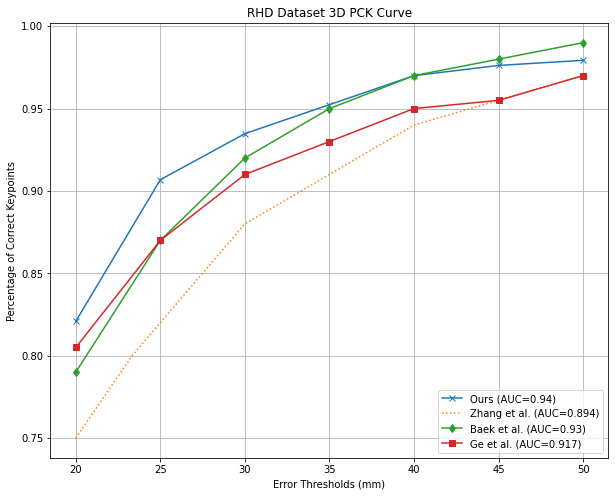

In [5]:
import evaluation
reload(evaluation)

# load desired model weights
checkpoint_path = os.path.join('../','checkpoints', "cp-{:04d}.ckpt".format(585))
model.load_weights(checkpoint_path)

train_list = qmindlib.get_train_list()
evaluation.evaluate_model(model, train_ds)